# An Empirical Analysis of Traceability in the Monero Blockchain

In [1]:
import itertools

In [2]:
import pandas as pd
import numpy as np
import scipy.stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import *

In [4]:
sns.set_style("ticks")
FIGSIZE = (8, 5)
%matplotlib notebook

In [5]:
from py2neo import Graph

In [6]:
password = "YOUR-PASSWORD-HERE"

In [7]:
graph = Graph(user="neo4j", password=password)

In [8]:
def to_data_frame(cursor):
    return pd.DataFrame(list(map(dict, cursor)))

## Deducible Inputs

### Number of deducible spends

- Returns all deducible spends between block heights `min_height` and `max_height`
- Returns the number of available mixins, the index of the true spend and of the mixins (to calculate the position)

In [9]:
def deducible_spends(min_height, max_height):
    query = """
      MATCH (o:UniqueSpend)<-[:SPENDS]-(:Input)<-[TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height >= {min_height} AND b.height < {max_height}
      WITH o
      MATCH (o)<-[:SPENDS]-(i:Input)-[:REFERENCES]->(x)
      WHERE NOT x = o AND i.anonset > 1000
      RETURN ID(i) as iid, i.anonset as anonset, o.index as idx, COLLECT(x.index) as refs, i.mixin as mixins
    """
    
    df = to_data_frame(graph.run(query, min_height=min_height, max_height=max_height))
    df.refs.apply(lambda x: x.sort(reverse=True))
    df['position'] = df.apply(lambda row: sorted(row.refs + [row.idx], reverse=True).index(row.idx), axis=1)
    return df

In [10]:
spends_uniform = deducible_spends(0, 1009827)

In [11]:
spends_triangular = deducible_spends(1009827, 1201528)

In [12]:
spends_recent = deducible_spends(1201528, 1288775) # 1288774 was the max height in our paper

### Total number of inputs

- Returns the total number of inputs with a certain amount of mixins between block heights `min_height` and `max_height`.
- Ignores inputs where less than 1000 possible mixins are available (i.e. `anonset > 1000`).
- Ignores RingCT transactions (i.e. `value > 0`).

In [13]:
def total_inputs(min_height, max_height):
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height >= {min_height} AND b.height < {max_height} AND i.anonset > 1000 AND i.value > 0
      WITH i
      RETURN i.mixin as mixins, COUNT(*) as cnt
    """
    df = pd.DataFrame(list(map(dict, graph.run(query, min_height=min_height, max_height=max_height))))
    # aggregate mixins >= 10 into a single value
    mixins_greater_ten = df[df.mixins >= 10].cnt.sum()
    df = df[df.mixins <= 10]
    df.loc[df.mixins == 10, 'cnt'] = mixins_greater_ten
    df = df.sort_values(by=['mixins'])
    return df

In [14]:
inputs_uniform = total_inputs(0, 1009827)

In [15]:
inputs_triangular = total_inputs(1009827, 1201528)

In [16]:
inputs_recent = total_inputs(1201528, 1288775)

### Table 2: Monero transaction inputs where the real input can be deduced

In [17]:
def compute_row_deducible(df, counts, mixin):
    if counts[counts.mixins == mixin].cnt.any():
        total = counts[counts.mixins == mixin].iloc[0].cnt
        deducible = len(df[(df.mixins == mixin)])
        percent = deducible / total
    else:
        total = 0
        deducible = 0
        percent = None
    result = pd.DataFrame({
        "total": total,
        "deducible": deducible,
        "percent": percent
    }, index=[mixin])
    return result[["total", "deducible", "percent"]]

In [18]:
total_deducible_uniform = pd.concat([compute_row_deducible(spends_uniform, inputs_uniform, mixin) for mixin in range(1, 11)])
total_deducible_triangular = pd.concat([compute_row_deducible(spends_triangular, inputs_triangular, mixin) for mixin in range(1, 11)])
total_deducible_recent = pd.concat([compute_row_deducible(spends_recent, inputs_recent, mixin) for mixin in range(1, 11)])

In [19]:
pd.concat([total_deducible_uniform, total_deducible_triangular, total_deducible_recent], axis=1)

,total,deducible,percent,total,deducible,percent,total,deducible,percent
1,683458,608087,0.889721,0,0,NaN,0,0,NaN
2,250520,206276,0.823391,1882681,1209259,0.642307,732251,308926,0.421885
3,634520,480500,0.757265,564525,376920,0.667676,126795,65738,0.518459
4,217493,156767,0.720791,376432,192348,0.510977,145687,33022,0.226664
5,87077,43214,0.496273,48806,26599,0.544994,3900,950,0.243590
6,115199,65546,0.568981,224202,119716,0.533965,24817,7890,0.317927
7,3671,1680,0.457641,4499,1770,0.393421,1711,235,0.137347
8,2216,1067,0.481498,5048,1968,0.389857,1458,249,0.170782
9,1811,838,0.462728,3264,1069,0.327512,264,48,0.181818
10,57363,7419,0.129334,46791,12237,0.261525,9145,1609,0.175943


### Table 3. Percentage of deducible transaction inputs where the real input is the “newest” input.

In [20]:
def compute_row_newest(df, mixin):
    if mixin < 10:
        deducible = len(df[(df.mixins == mixin)])
        newest = len(df[(df.mixins == mixin) & (df.position == 0)])
    else:
        deducible = len(df[(df.mixins >= mixin)])
        newest = len(df[(df.mixins >= mixin) & (df.position == 0)])
    if deducible > 0:
        percent = newest / deducible
    else:
        percent = None
    return pd.DataFrame({
        "deducible": deducible,
        "newest": newest,
        "percent": percent
    }, index=[mixin])

In [21]:
percent_deducible_uniform = pd.concat([compute_row_newest(spends_uniform, mixin) for mixin in range(1, 11)])
percent_deducible_triangular = pd.concat([compute_row_newest(spends_triangular, mixin) for mixin in range(1, 11)])
percent_deducible_recent = pd.concat([compute_row_newest(spends_recent, mixin) for mixin in range(1, 11)])

In [22]:
pd.concat([percent_deducible_uniform, percent_deducible_triangular, percent_deducible_recent], axis=1)

,deducible,newest,percent,deducible,newest,percent,deducible,newest,percent
1,608087,585424,0.962731,0,0,NaN,0,0,NaN
2,206276,191372,0.927747,1209259,1126924,0.931913,308926,293051,0.948612
3,480500,461154,0.959738,376920,353246,0.937191,65738,59693,0.908044
4,156767,139626,0.890659,192348,149722,0.778391,33022,18889,0.572013
5,43214,39854,0.922247,26599,24971,0.938795,950,473,0.497895
6,65546,51816,0.790529,119716,102378,0.855174,7890,6458,0.818504
7,1680,1522,0.905952,1770,989,0.558757,235,115,0.489362
8,1067,964,0.903468,1968,1310,0.665650,249,163,0.654618
9,838,692,0.825776,1069,355,0.332086,48,40,0.833333
10,11997,10822,0.902059,12970,11750,0.905937,1682,1480,0.879905


### Figure 5: Fraction of transaction inputs that can be deduced and transactions including at least one deducible input

In [23]:
def time_all_inputs():
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      RETURN b.timestamp as timestamp, COUNT(i) as cnt
    """
    df = to_data_frame(graph.run(query))
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.resample('1d', on='timestamp').sum()
    return df

In [24]:
def time_zero_mixins():
    query = """
      MATCH (i:Input)
      WHERE i.mixin = 0
      WITH i
      MATCH (i)<-[:TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      RETURN b.timestamp as timestamp, COUNT(i) as cnt
    """
    df = to_data_frame(graph.run(query))
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.resample('1d', on='timestamp').sum()
    return df

In [25]:
def time_deducible():
    query = """
      MATCH (i:Input)
      WHERE (i)-[:SPENDS]->()
      WITH i
      MATCH (i)<-[:TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      RETURN b.timestamp as timestamp, COUNT(i) as cnt
    """
    df = to_data_frame(graph.run(query))
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.resample('1d', on='timestamp').sum()
    return df

In [26]:
def time_all_transactions():
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(tx:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height > 0 AND NOT tx:Coinbase AND i.mixin > 0
      RETURN b.timestamp as timestamp, COUNT(DISTINCT(tx)) as cnt
    """
    df = to_data_frame(graph.run(query))
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.resample('1d', on='timestamp').sum()
    return df

In [27]:
def time_deducible_transactions():
    query = """
      MATCH ()<-[:SPENDS]-(i:Input)<-[:TX_INPUT]-(tx:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height > 0 AND i.mixin > 0
      WITH tx, b.timestamp as timestamp
      RETURN timestamp, COUNT(DISTINCT(tx)) as cnt
    """
    df = to_data_frame(graph.run(query))
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.resample('1d', on='timestamp').sum()
    return df

In [28]:
df_time_all_inputs = time_all_inputs()
df_time_zero_mixins = time_zero_mixins()
df_time_deducible = time_deducible()
df_time_all_transactions = time_all_transactions()
df_time_deducible_transactions = time_deducible_transactions()

In [49]:
df_time = pd.DataFrame({
    "All deducible inputs": df_time_deducible.div(df_time_all_inputs).cnt,
    "0 mixin inputs": df_time_zero_mixins.div(df_time_all_inputs).cnt,
    "Deducible transactions": df_time_deducible_transactions.div(df_time_all_transactions).cnt
}, index=df_time_all_transactions.index)

<IPython.core.display.Javascript object>


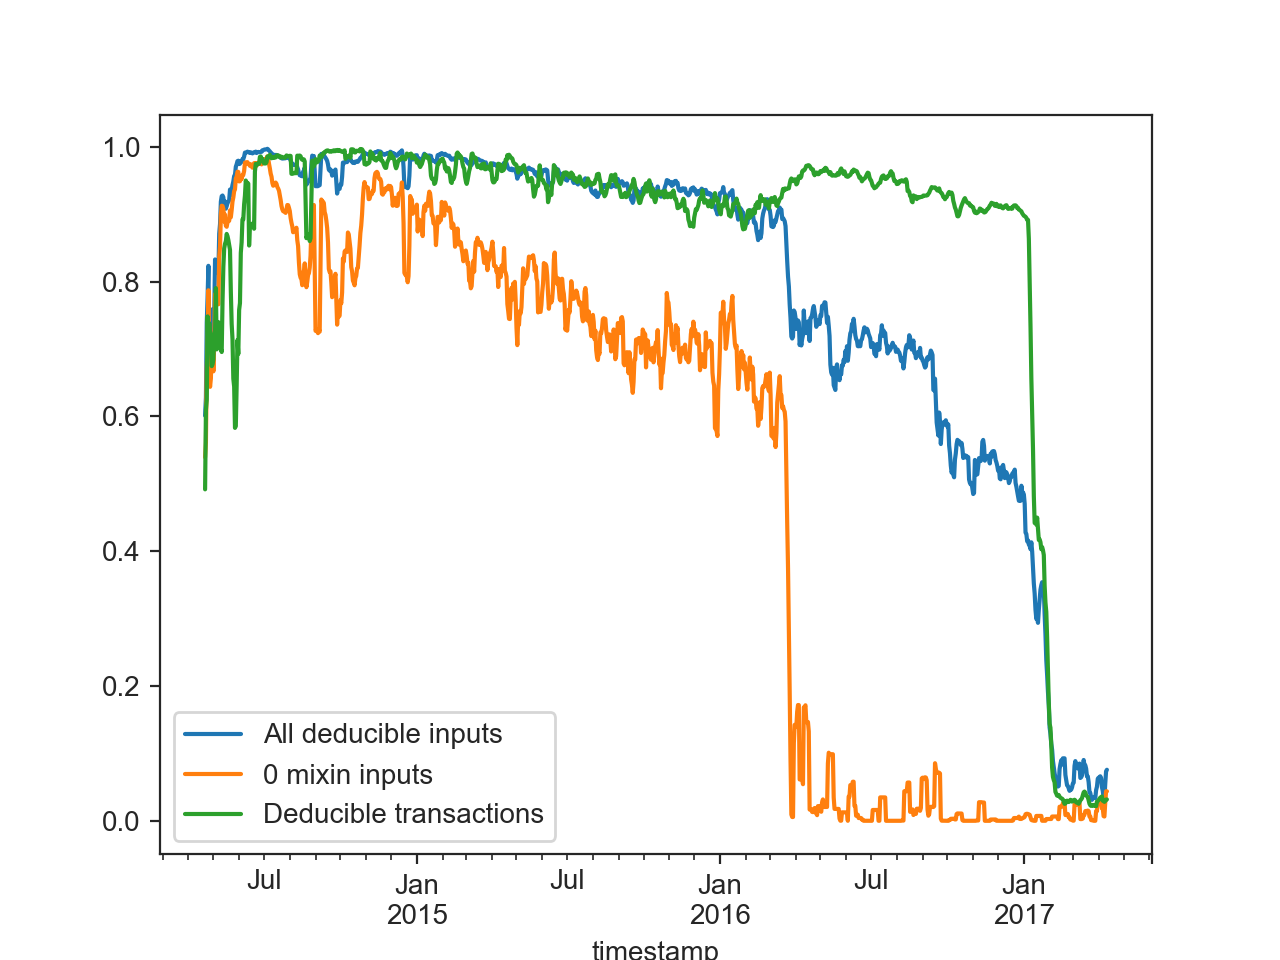

In [50]:
df_time.resample("1d").mean().fillna(0).rolling(window=7, min_periods=7, center=True).mean().plot()

## Age distributions

### All Inputs

In [31]:
def age_dist_all():
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height >= 900000 AND b.height <= 1200000 AND i.anonset > 1000
      WITH i, b.timestamp as ts1
      MATCH (i)-[:REFERENCES]->(o:Output)<-[:TX_OUTPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      RETURN ID(i) as inId, COLLECT(ts1 - b.timestamp) as times
    """
    df = to_data_frame(graph.run(query))
    return df

In [32]:
df_age_all = age_dist_all()

In [33]:
age_all = list(itertools.chain.from_iterable(df_age_all.times))
age_all = [x / (24*60*60) for x in age_all]

<IPython.core.display.Javascript object>


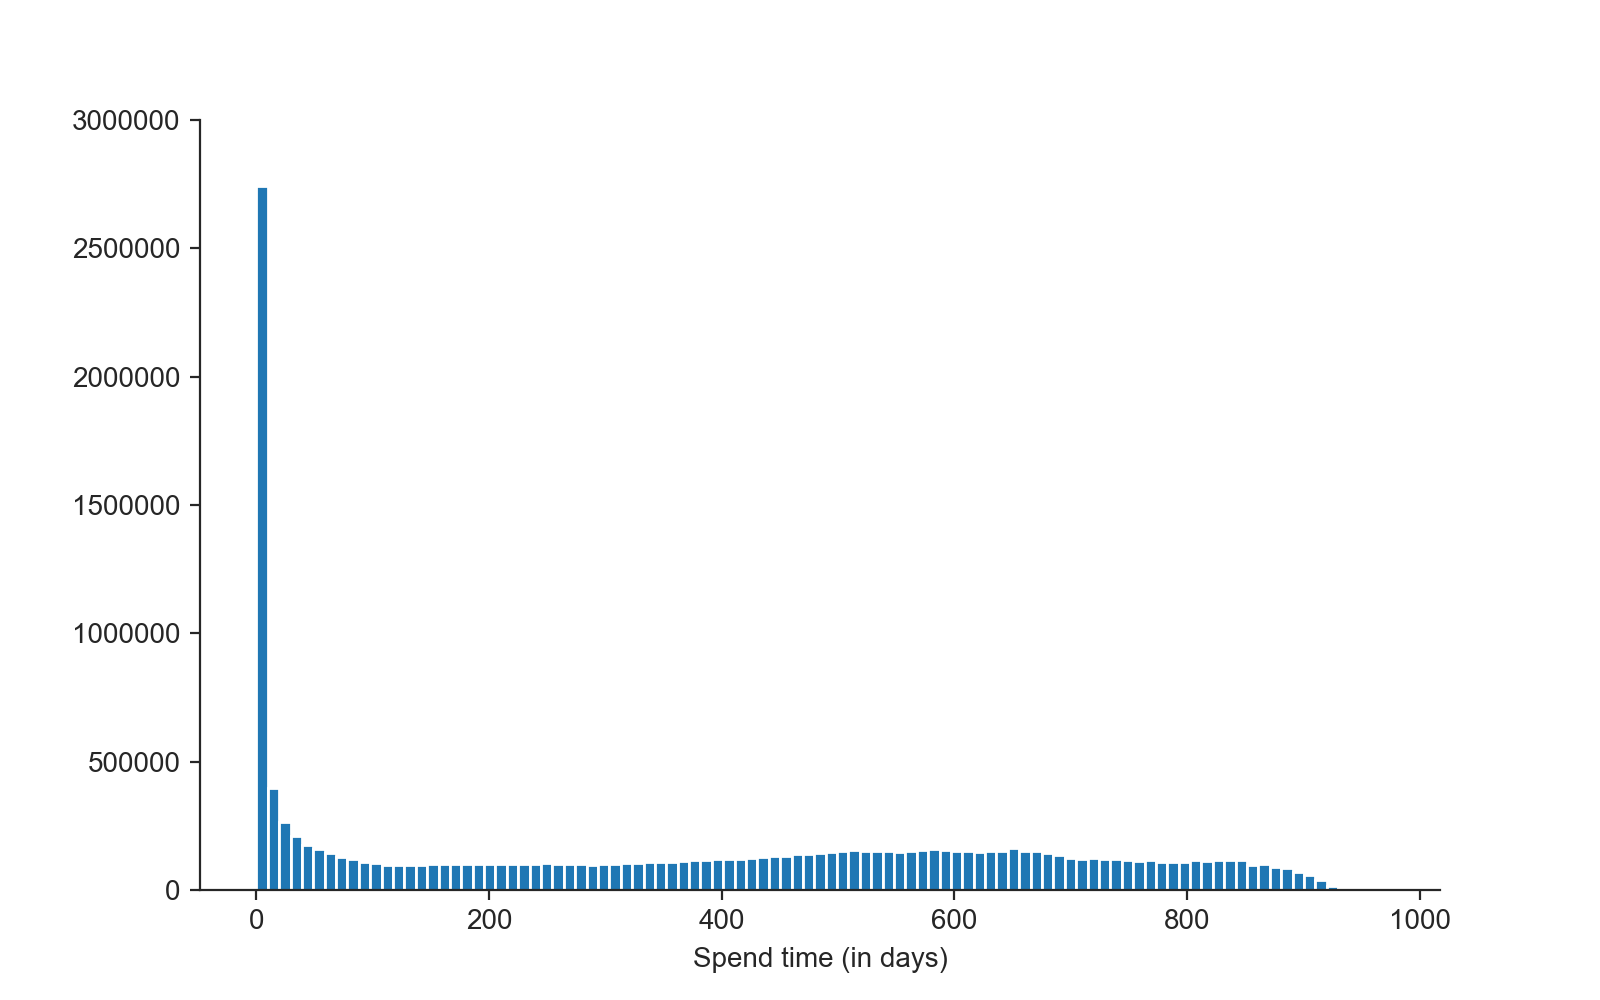

In [34]:
plt.figure(figsize=FIGSIZE)
plt.hist(age_all, 99)

plt.yticks(range(0, 3500000, 500000), [x for x in range(0, 3500000, 500000)])

plt.xlabel('Spend time (in days)')
sns.despine()
plt.show()

### Ruled out

In [35]:
def age_dist_fake():
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(tx:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE b.height >= 900000 AND b.height <= 1200000 AND i.anonset > 1000
      WITH i, b.timestamp as ts1
      MATCH (i)-[:REFERENCES]->(o:UniqueSpend)<-[:TX_OUTPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      WHERE NOT (i)-[:SPENDS]->(o)
      RETURN ID(i) as inId, COLLECT(ts1 - b.timestamp) as times
    """
    df = to_data_frame(graph.run(query))
    return df

In [36]:
df_age_fake = age_dist_fake()

In [37]:
age_fake = list(itertools.chain.from_iterable(df_age_fake.times))
age_fake = [x / (24*60*60) for x in age_fake]

<IPython.core.display.Javascript object>


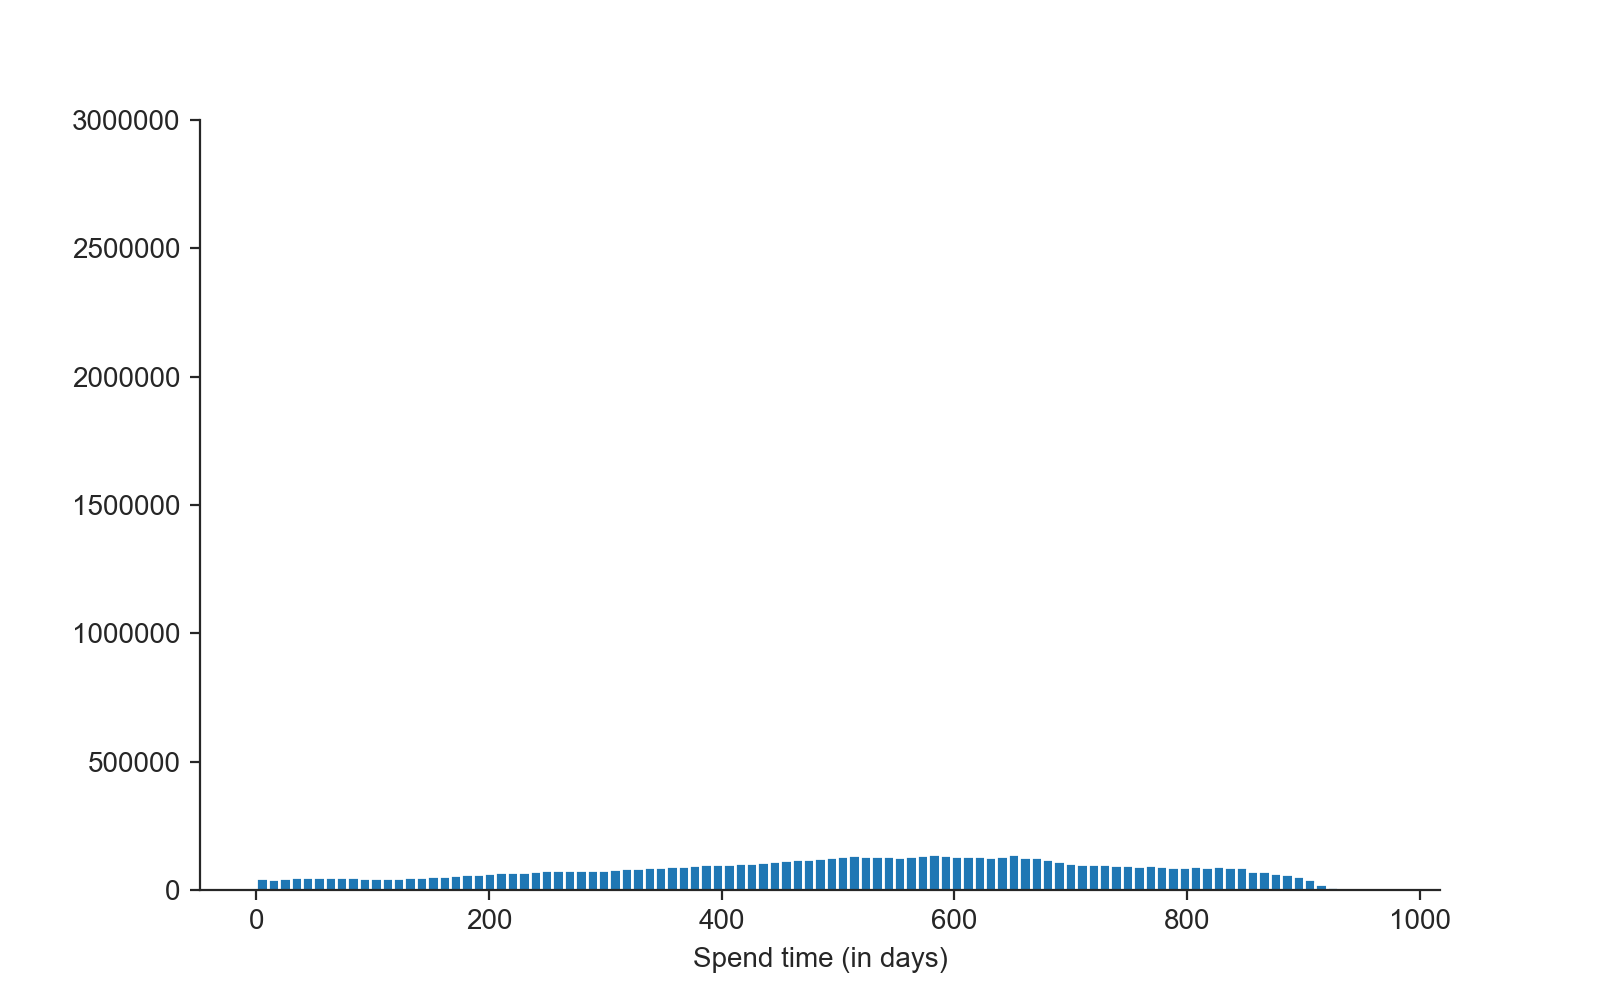

In [38]:
plt.figure(figsize=FIGSIZE)
plt.hist(age_fake, 99)

plt.yticks(range(0, 3500000, 500000), [x for x in range(0, 3500000, 500000)])

plt.xlabel('Spend time (in days)')
sns.despine()
plt.show()

### True spends

In [39]:
def age_dist_true():
    query = """
      MATCH ()<-[:SPENDS]-(i:Input)<-[:TX_INPUT]-(tx:Transaction)-[:IN_BLOCK]->(b)
      WHERE b.height >= 900000 AND b.height <= 1200000 AND i.mixin > 0 AND i.anonset > 1000
      WITH i, b.timestamp as ts1
      MATCH (i)-[:SPENDS]->(o:UniqueSpend)<-[:TX_OUTPUT]-(:Transaction)-[:IN_BLOCK]->(b:Block)
      RETURN ID(i) as inId, COLLECT(ts1 - b.timestamp) as times
    """
    df = to_data_frame(graph.run(query))
    return df

In [40]:
df_age_true = age_dist_true()

In [41]:
age_true = list(itertools.chain.from_iterable(df_age_true.times))
age_true = [x / (24*60*60) for x in age_true]

<IPython.core.display.Javascript object>


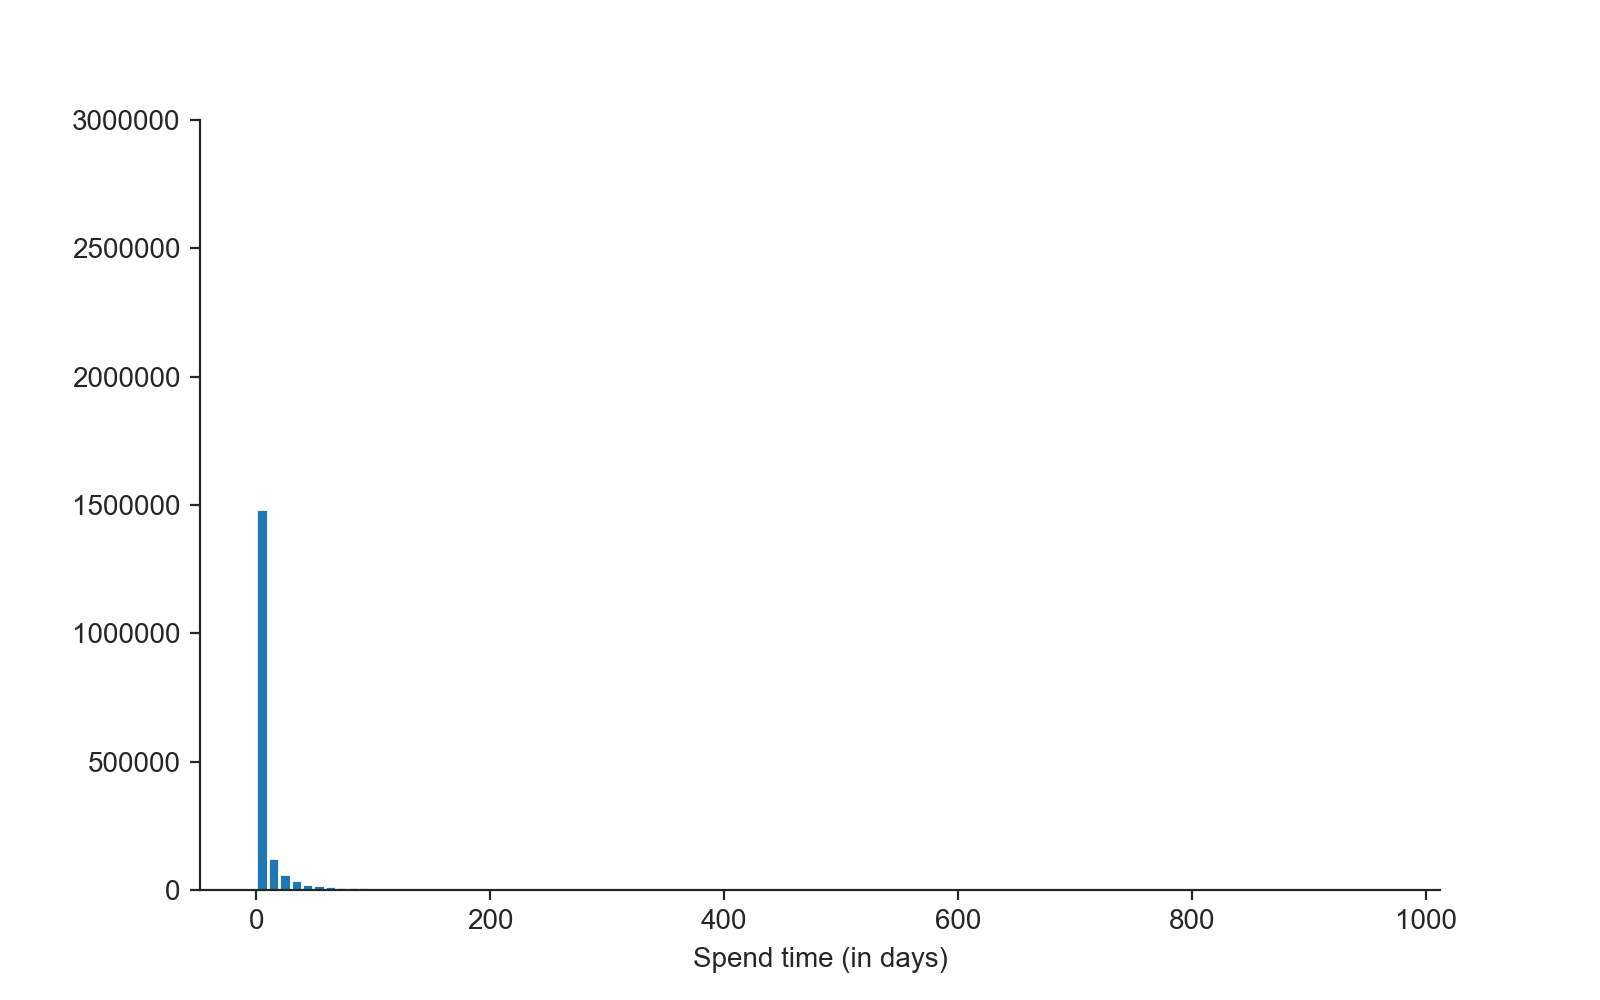

In [42]:
plt.figure(figsize=FIGSIZE)
plt.hist(age_true, 99)

plt.yticks(range(0, 3500000, 500000), [x for x in range(0, 3500000, 500000)])

plt.xlabel('Spend time (in days)')
sns.despine()
plt.show()

## Fit Distribution to Ground Truth

In [43]:
def spendTimes():
    query = """
      MATCH (i:Input)<-[:TX_INPUT]-(tx:Transaction)-[:IN_BLOCK]->(b2:Block)
      WHERE i.mixin > 0 AND (i)-[:SPENDS]->()
      WITH i, b2.timestamp as ts
      MATCH (b1:Block)<-[:IN_BLOCK]-(:Transaction)-[:TX_OUTPUT]->(:Output)<-[:SPENDS]-(i)
      RETURN ID(i) as iId, ts - b1.timestamp as timeDiff
    """
    df = to_data_frame(graph.run(query))
    return df

In [44]:
df_spend_times = spendTimes()

In [45]:
df_spend_times.loc[df_spend_times['timeDiff'] <= 0, 'timeDiff'] = 1

In [46]:
log_spend_times = np.log(df_spend_times.timeDiff)

In [47]:
shape, loc, scale = scipy.stats.gamma.fit(log_spend_times)

In [48]:
print("Gamma Distribution")
print("Shape: {}, Rate: {}".format(round(shape, 2), round(1/scale, 2)))

Gamma Distribution
Shape: 19.54, Rate: 1.61
